In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

The dataset is too big so we will only use a sample from this dataset

In [5]:
try:
    data = df.sample(10000, random_state = 42)
    print("Done with making the sample")
except Exception as e:
    print(e)

Done with making the sample


In [6]:
df = data

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 8067 to 224657
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [10]:
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc if
        not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

In [11]:
df["clean_q1"] = df["question1"].apply(preprocess)

In [12]:
df["clean_q2"] = df["question2"].apply(preprocess)

In [13]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,play pokémon korea,play pokémon china
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,good dish crab cake,good dish buffalo chicken
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,advisable well material crash test automobile ...,good server setup buddypress
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,improve logical programming skill,improve logical skill programming
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,close 3rd world war,close world war iii


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer()
all_ques = pd.concat([df["clean_q1"], df["clean_q2"]])
tfidf.fit_transform(all_ques)

<20000x11980 sparse matrix of type '<class 'numpy.float64'>'
	with 97048 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
similarity_matrix = cosine_similarity(tfidf.transform(df["clean_q1"]), tfidf.transform(df["clean_q2"]))

df["sim"] = [similarity_matrix[i, i] for i in range(len(df))]

In [24]:
df["sim"] = (df.sim >= .75).astype('int64')

In [25]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2,sim
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,play pokémon korea,play pokémon china,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,good dish crab cake,good dish buffalo chicken,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,advisable well material crash test automobile ...,good server setup buddypress,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,improve logical programming skill,improve logical skill programming,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,close 3rd world war,close world war iii,0


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(df["is_duplicate"], df["sim"]))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6265
           1       0.54      0.50      0.52      3735

    accuracy                           0.66     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.65      0.66      0.65     10000



In [30]:
conf_matrix = confusion_matrix(df["is_duplicate"], df["sim"])
print(conf_matrix)

[[4701 1564]
 [1884 1851]]


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

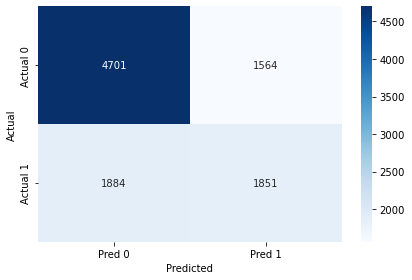

In [33]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()